# Altering time discretization

This tutorial was prepared by Alexandre Olender. If you have any questions, please email: olender@usp.br

This tutorial is specifically tailored for developers of Spyro, an open-source Python library for modeling waves. Spyro provides a user-friendly interface built on top of Firedrake, making working with complex mathematical models easier. Before you begin this tutorial, it is recommended that you familiarize yourself either with Firedrake (https://www.firedrakeproject.org/documentation.html) or FEniCS (which uses the same domain-specific language called Unified Form Language - UFL). Firedrake is an automated system for the solution of partial differential equations using the finite element method (FEM). In addition to the prerequisite knowledge of Firedrake or FEniCS, a solid understanding of Python programming and basic concepts of numerical methods will be beneficial. 

This tutorial, however, does not delve into the details of finite element methods.

By the end of this tutorial, you will have the skills to start implementing explicit time integration schemes in Spyro.

In [1]:
# Code in this cell enables plotting in the notebook
%matplotlib inline
import spyro

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


## Wave class

The `Wave` class in spyro provides a base class for any wave propagator.

In [2]:
help(spyro.Wave)

Help on class Wave in module spyro.solvers.wave:

class Wave(spyro.io.model_parameters.Model_parameters)
 |  Wave(dictionary=None, comm=None)
 |  
 |  Base class for wave equation solvers.
 |  
 |  Attributes:
 |  -----------
 |  comm: MPI communicator
 |  
 |  initial_velocity_model: firedrake function
 |      Initial velocity model
 |  function_space: firedrake function space
 |      Function space for the wave equation
 |  current_time: float
 |      Current time of the simulation
 |  solver_parameters: Python object
 |      Contains solver parameters
 |  real_shot_record: firedrake function
 |      Real shot record
 |  wavelet: list of floats
 |      Values at timesteps of wavelet used in the simulation
 |  mesh: firedrake mesh
 |      Mesh used in the simulation (2D or 3D)
 |  mesh_z: symbolic coordinate z of the mesh object
 |  mesh_x: symbolic coordinate x of the mesh object
 |  mesh_y: symbolic coordinate y of the mesh object
 |  sources: Sources object
 |      Contains informa

It is highly recommended that every wave solver inherit this class. Two of the methods present in it are abstract methods. This means that any concrete class derived from it needs to define them. They are the matrix_building and the forward_solve methods. The matrix_building method is not the subject of this tutorial; however, we have to consider its outputs. The name itself is counterintuitive since it does not necessarily have to build a matrix. However, we will momentarily deal with it as having matrices for teaching purposes. Spyro focuses on solving time-dependent wave equations. After doing the finite element-based spatial discretization, we should have a time-dependent equation with something analogous to the following:

$A_1 \ddot{Q} + A_2 \dot{Q} + A_3 Q = F$

For most cases in seismic imaging, we limit ourselves to explicit time integration schemes. Several papers have examined their advantages compared to implicit schemes when dealing with PDEs encountered for seismic imaging. However, this is not a rigorous rule. Studying new implicit schemes is an exciting area of research with various promising developments. We do limit our scope in this tutorial to only explicit schemes. In these schemes, we can discretize the above equation in time to make a result at a given timestep an explicit function of the previous ones. In other words, the result at a timestep n+1 can be written as:

$Q_{n+1} = M^{-1}(B_0 Q_{n} + B_1 Q_{n-1} + B_2 Q_{n-2} + ... + B_n)$

Not every previous $Q$ solution at a timestep needs to be used, since every variable we store increases our memory storage cost. For this tutorial we will focus on an integration scheme that only saves $Q_n$ and $Q_{n-1}$, therefore our equation above has to take the form:

$Q_{n+1} = M^{-1}(B_0 Q_{n} + B_1 Q_{n-1} + B_2)$

Therefore, our time marching scheme has to apply a solver operator, where the previous values for $Q$ are known and calculate $Q_{n+1}$. Afterward, $Q_n$ and $Q_{n-1}$ have to be updated. I have used $Q$ instead of $u$ or $p$ for the desired time-dependent variable we are calculating for, because our PDE can actually be a system of equations with various time-dependent auxiliariary variables. In those cases, we use a mixed-function space, and the pressure-related space has to be first.

Let us build an acoustic wave object. For simplicity, I will use a rectangle example (see premade useful examples tutorial).

In [3]:
dictionary = {}
dictionary["mesh"] = {
    "Lz": 3.0,  # depth in km - always positive
    "Lx": 4.0,  # width in km - always positive
    "h": 0.1,  # mesh size in km
}
dictionary["absorving_boundary_conditions"] = {
    "status": False,
    "pad_length": 0.,
}
dictionary["acquisition"] = {
    "source_locations": [(-0.1, 2.0)],
    "receiver_locations": spyro.create_transect((-1.0, 0.0), (-1.0, 4.0), 20),
}
Wave_obj = spyro.examples.Rectangle_acoustic(dictionary=dictionary)
layer_values = [1.5, 2.5, 3.5]
z_switches = [-1.0, -2.0]
Wave_obj.multiple_layer_velocity_model(z_switches, layer_values)

# to visualize

Parallelism type: automatic


/home/alexandre/Development/tutorials/spyro-1/spyro/solvers/wave.py:85: UserWarning: No mesh file, Firedrake mesh will be automatically generated.
  warnings.warn(


File name model.png


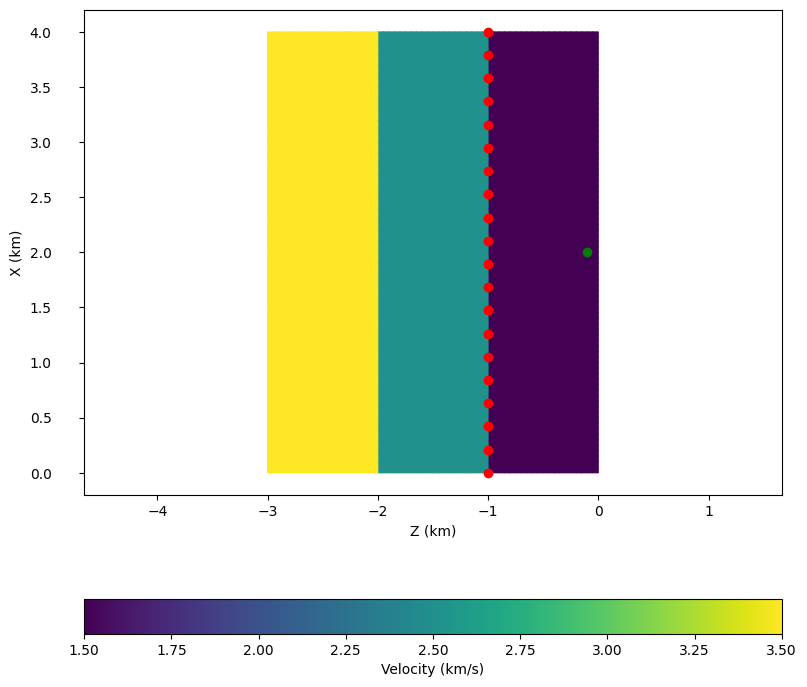

In [4]:
spyro.plots.plot_model(Wave_obj, show=True, flip_axis=False)

Before propagating our wave, we have to define the velocity model for the solver operator and construct it.

In [5]:
Wave_obj._get_initial_velocity_model()
Wave_obj.c = Wave_obj.initial_velocity_model
Wave_obj.matrix_building()

The `_get_initial_velocity_model` is not actually necessary for this specific case (where the velocity model is already created in the object) and does not do anything in this case. However, it needs to be called, because in larger cases the velocity model is only loaded, by this method, into our function space right before it is needed (to conserve memory). Spyro will build the solver object based on the velocity model that the `c` attribute points to. This can be diferent than the `initial_velocity_model`, especially in inversion problems.

Before we propagate our wave, we can now calculate the maximum upper bound of a stable timestep based on the spectral radius of our mass matrix. The actual maximum stable timestep can vary depending on the discretization used. If you are using lumped elements you can estimate the spectral radius to reduce total runtime of this calculation. 

In [7]:
Wave_obj.get_and_set_maximum_dt(fraction=0.8, estimate_max_eigenvalue=True)
print(f"Timstep used: {Wave_obj.dt}")

Timstep used: 0.0014619883040935672


We can now focus on the time discretization. The source_id variable illustrates which sources we will be propagating. Inside the forward_solve method there is a wrapper to distribute them while taking into account our parallelism strategy. If you are making a new method you only have to copy that wrapper and put source_id as an input to your method.

In [9]:
import firedrake as fire
source_id = 0

Here we just get the variables we will use from the corresponding object.

In [15]:
excitations = Wave_obj.sources
excitations.current_source = source_id
receivers = Wave_obj.receivers

output_filename = "forward_time_scheme_tutorial.pvd"
output = fire.File(output_filename)

final_time = Wave_obj.final_time
dt = Wave_obj.dt
t = Wave_obj.current_time

The next code is very simple, but a common source of error. Please calculate the number of timesteps based on final time and current time. Don't forget to add one when calculating the number of timesteps!

In [10]:
nt = int((final_time - t) / dt) + 1  # ANSWER

Firedrake stores data on Function objects. This is where we will save our solutions. u_nm1 and u_n are also functions in the same function space, that were previously defined. If you want to use more previous timesteps you have to add them too. To save space we will save the whole solution field of our pressure variable only for the necessary steps used in gradient calculation, with u_sol.

In [11]:
X = fire.Function(Wave_obj.function_space)

u_nm1 = Wave_obj.u_nm1
u_n = Wave_obj.u_n
u_np1 = fire.Function(Wave_obj.function_space)

usol = [
    fire.Function(Wave_obj.function_space, name="pressure")
    for t in range(nt)
    if t % Wave_obj.gradient_sampling_frequency == 0
]

Our system has a right hand that can be calculated (based on the previous time-steps). Here we save a function to hold those values (`Function` objects in Firedrake have values and are always initialized with zeros). The rhs is actually a symbolic object that calcutes our right hand side. Everytime we change a variable in it we have to reassemble it.

In [12]:
rhs_forcing = fire.Function(Wave_obj.function_space)
usol_recv = []
save_step = 0
B = Wave_obj.B
rhs = Wave_obj.rhs

The apply_source method projects our time-dependent source into our function space and saves the values in the relevant degrees of freedom. The following code does not have the update of the rpevious time steps. Please add them.

In [13]:
for step in range(nt):
    rhs_forcing.assign(0.0)
    B = fire.assemble(rhs, tensor=B)
    f = excitations.apply_source(rhs_forcing, Wave_obj.wavelet[step])
    B0 = B.sub(0)
    B0 += f
    Wave_obj.solver.solve(X, B)

    u_np1.assign(X)

    usol_recv.append(
        Wave_obj.receivers.interpolate(u_np1.dat.data_ro_with_halos[:])
    )

    if step % Wave_obj.gradient_sampling_frequency == 0:
        usol[save_step].assign(u_np1)
        save_step += 1

    if (step - 1) % Wave_obj.output_frequency == 0:
        assert (
            fire.norm(u_n) < 1
        ), "Numerical instability. Try reducing dt or building the \
            mesh differently"
        if Wave_obj.forward_output:
            output.write(u_n, time=t, name="Pressure")

    u_nm1.assign(u_n)  # ANSWER
    u_n.assign(u_np1)  # ANSWER

    t = step * float(dt)


In [14]:
Wave_obj.current_time = t

Wave_obj.receivers_output = usol_recv

Wave_obj.forward_solution = usol
Wave_obj.forward_solution_receivers = usol_recv